In [1]:
# for each baseline model of number of iterations X
# put its performance in the middle as a bar.
# then, put models leD1, leD2 ... ,leD{X-1} on its left.
# put models geD2, geD3, ..., geD{X} to its right.

# remember, only consider those models that have all variants (original + all leD + all geD) available.

from os.path import join
from os import makedirs
from thesis_v2 import dir_dict
from thesis_v2.plots.util import savefig

In [2]:
import pandas as pd
import numpy as np

In [3]:
f_main_result = join(dir_dict['analyses'], 'yuanyuan_8k_a_3day_refactored', '20201205+20201205_2', 'main.pkl')
f_main_result_2 = join(dir_dict['analyses'], 'yuanyuan_8k_a_3day_refactored', '20201213+20201213_2', 'main.pkl')
dir_plot = join(dir_dict['plots'], 'yuanyuan_8k_a_3day_refactored', '20201205+20201205_2+20201213+20201213_2')
makedirs(dir_plot, exist_ok=True)
df_main_result = pd.read_pickle(f_main_result)
df_main_result_2 = pd.read_pickle(f_main_result_2)

df_main_result = pd.concat([df_main_result, df_main_result_2], axis=0).sort_index()
assert df_main_result.index.is_unique

In [4]:
df_main_result

cc2_normed_avg  \
act_fn   ff_1st_bn_before_act loss_type model_seed multi_path_hack num_layer out_channel rcnn_bl_cls readout_type train_keep                   
relu     False                mse       0          geD1            2         16          2           cm-avg       5120              0.612730   
                                                                                                     cm-last      5120              0.642350   
                                                                                                     inst-avg     5120              0.629425   
                                                                                                     inst-last    5120              0.645303   
                                                                                         3           cm-avg       5120              0.622867   
...                                                                                                                                      ...   
softplus True                 poisson   1          leD7            2         16          7           inst-last    5120              0.625185   
                                                                             32          7           cm-avg       5120                   NaN   
                                                                                                     cm-last      5120                   NaN   
                                                                                                     inst-avg     5120                   NaN   
                                                                                                     inst-last    5120                   NaN   

                                                                                                                              cc2_raw_avg  \
act_fn   ff_1st_bn_before_act loss_type model_seed multi_path_hack num_layer out_channel rcnn_bl_cls readout_type train_keep                
relu     False                mse       0          geD1            2         16          2           cm-avg       5120           0.282988   
                                                                                                     cm-last      5120           0.296313   
                                                                                                     inst-avg     5120           0.290298   
                                                                                                     inst-last    5120           0.297253   
                                                                                         3           cm-avg       5120           0.287609   
...                                                                                                                                   ...   
softplus True                 poisson   1          leD7            2         16          7           inst-last    5120           0.288450   
                                                                             32          7           cm-avg       5120                NaN   
                                                                                                     cm-last      5120                NaN   
                                                                                                     inst-avg     5120                NaN   
                                                                                                     inst-last    5120                NaN   

                                                                                                                              cc_raw_avg  \
act_fn   ff_1st_bn_before_act loss_type model_seed multi_path_hack num_layer out_channel rcnn_bl_cls readout_type train_keep               
relu     False                mse       0          geD1            2         16          2           cm-avg       5120          0.513442   

In [5]:
def get_geD1_perf(perf):
    ret = perf.xs('geD1', level='multi_path_hack')
    return ret.sort_index().rename('geD1')

def get_leDX_perf(perf):
    ret = perf[
        perf.index.get_level_values(
            'multi_path_hack'
            # here .values is important. otherwise this code does not work properly. not sure why.
            # pandas is complicated.
        ).map(lambda x: x.startswith('leD')).values & (
             perf.index.get_level_values('multi_path_hack').map(lambda x: int(x[3:])) ==  perf.index.get_level_values('rcnn_bl_cls')
        )
    ]
                                                                                             
    return ret.droplevel('multi_path_hack').sort_index().rename('leDX')

def get_original_perf(ref_perf, perf_column):
    ret = pd.concat(
    [
        pd.read_pickle(join(dir_dict['analyses'], 'yuanyuan_8k_a_3day_refactored', '20201118', 'main_result_separatebn.pkl')),
        pd.read_pickle(join(dir_dict['analyses'], 'yuanyuan_8k_a_3day_refactored', '20201114', 'main_result_separatebn.pkl')),
    ], axis=0
).dropna()[perf_column]
    index = ref_perf.xs('geD1', level='multi_path_hack').index
    assert index.names == ret.index.names
    return ret[index].sort_index().rename('original')

In [12]:
def get_baseline_perf(df, *, perf_col):
    # this is average of geD1, leDX, as well as original models trained in 20201114+20201118.
    perf = df[perf_col]
    df1 = get_geD1_perf(perf)
    df2 = get_leDX_perf(perf)
    df3 = get_original_perf(perf, perf_col)
    assert df1.index.equals(df2.index)
    assert df1.index.equals(df3.index)
    
    assert df1.shape == df2.shape == df3.shape == (384*2,)
    
    # take average
    merged = pd.concat([df1, df2, df3], axis=1)
    return merged.mean(axis=1).dropna()

In [13]:
def main_loop(df, *, perf_col='cc2_normed_avg'):
    baseline_perf = get_baseline_perf(df, perf_col=perf_col)
    # cycle over different readout_type, and num_channel
    index_num_layer = baseline_perf.index.get_level_values('num_layer').values
    index_out_channel = baseline_perf.index.get_level_values('out_channel').values
    index_readout_type = baseline_perf.index.get_level_values('readout_type').values

    index_layer_ch_readout = np.asarray(
        [index_num_layer, index_out_channel, index_readout_type]
    ).T.tolist()
    index_layer_ch_readout = [tuple(x) for x in index_layer_ch_readout]
    # np.unique does not work, because index_readout_type here is of `object` dtype. too generic for numpy
    # TypeError: The axis argument to unique is not supported for dtype object
    unique_layer_ch_readout = sorted(set(index_layer_ch_readout))
    perf_all=df[perf_col]
    for key_this in unique_layer_ch_readout:

        num_l, num_ch, readout = key_this
        print(key_this)
        inner_loop(
            perf_all=perf_all, perf_baseline=baseline_perf,
            num_l = num_l, num_ch = num_ch, readout = readout
        )
    print('overall')
    inner_loop(
            perf_all=perf_all, perf_baseline=baseline_perf,
            num_l = None, num_ch = None, readout = None
    )

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

In [15]:
from scipy.stats import sem

In [16]:
def inner_loop(
    *,
    perf_all, perf_baseline,
    num_l, num_ch, readout
):
    # first, get all baseline models in this case
    
    if num_l is None and num_ch is None and readout is None:
        perf_baseline_this = perf_baseline
        perf_all_this = perf_all
        suffix = 'all'
    else:
        assert num_l is not None and num_ch is not None and readout is not None
        perf_baseline_this = perf_baseline.xs(
            key=(num_l, num_ch, readout), level=('num_layer', 'out_channel', 'readout_type')
        )

        perf_all_this = perf_all.xs(
            key=(num_l, num_ch, readout), level=('num_layer', 'out_channel', 'readout_type')
        )
        suffix = f'l{num_l},ch{num_ch},{readout}'

    print(perf_baseline_this.shape, perf_all_this.shape)
    
    inner_loop_helper(perf_baseline_this=perf_baseline_this, perf_all_this=perf_all_this, suffix=suffix)
    
def inner_loop_helper(
    *,
    perf_baseline_this, perf_all_this, suffix
):
    # ok.
    # get all cls
    unique_cls = perf_baseline_this.index.get_level_values('rcnn_bl_cls').unique()
    assert np.array_equal(unique_cls, np.arange(2, unique_cls[-1]+1))
    max_cls = unique_cls[-1]
    
    plt.close('all')
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8, 5), squeeze=True)
    
    for cls_this in unique_cls:
        # get all models
        perf_baseline_this_cls = perf_baseline_this.xs(cls_this, level='rcnn_bl_cls').sort_index()
        
        # get all models in this cls, all
        perf_all_this_cls = perf_all_this.xs(cls_this, level='rcnn_bl_cls')
        
        # put models leD1, leD2 ... ,leD{X-1} on its left.
        # put models geD2, geD3, ..., geD{X} to its right.
        
        data_all_to_plot_mean = []
        data_all_to_plot_err = []
        
        for d_lower in range(1, cls_this):
            data_this = inner_loop_helper_inner(
                perf_baseline_this_cls=perf_baseline_this_cls,
                perf_all_this_cls=perf_all_this_cls,
                spec=f'leD{d_lower}'
            )
            data_all_to_plot_mean.append(data_this['mean'])
            # sem typically gives better results.
            data_all_to_plot_err.append(data_this['sem'])
        
        # plot itself.
        data_this_base = inner_loop_helper_inner(
            perf_baseline_this_cls=perf_baseline_this_cls,
            perf_all_this_cls=perf_all_this_cls,
            spec=None,
        )
        data_all_to_plot_mean.append(data_this_base['mean'])
        data_all_to_plot_err.append(data_this_base['sem'])
        
        for d_higher in range(2, cls_this+1):
            data_this = inner_loop_helper_inner(
                perf_baseline_this_cls=perf_baseline_this_cls,
                perf_all_this_cls=perf_all_this_cls,
                spec=f'geD{d_higher}'
            )
            data_all_to_plot_mean.append(data_this['mean'])
            # sem typically gives better results.
            data_all_to_plot_err.append(data_this['sem'])
        assert len(data_all_to_plot_mean) == len(data_all_to_plot_err) == 2*(cls_this) - 1
        # so that every one has original perf in the middle.
        offset = max_cls - cls_this
        ax.errorbar(
            x=np.arange(2*(cls_this) - 1) + offset,
            y=np.array(data_all_to_plot_mean)-data_this_base['mean'],
#             y=np.array(data_all_to_plot_mean),
                   yerr=np.array(data_all_to_plot_err
                                ), label=str(cls_this))
    
    ax.legend(loc='best', title='number of iterations T')
    
    ax.set_ylabel('''$\\Delta$ of average ${\\mathrm{CC}}_{\\mathrm{norm}}^2$''')
    ax.set_xticks(np.arange(2*(max_cls) - 1))
    ax.set_xticklabels(
        # TODO: fix this for num_layer = 3 models.
        [f'|p| <= T-{d_lower}' for d_lower in range(1, max_cls)[::-1]] + 
        ['|p| = 1,...,T'] + 
        [f'|p| >= {d_higher}' for d_higher in range(2, cls_this+1)], rotation=45
    )
    ax.set_title(f'performance change of keeping only paths of certain length |p|, over {perf_baseline_this.size} full models')
    ax.axhline(y=0,color='k',linestyle='--')
    
    fig.subplots_adjust(left=0.1, right=0.975, bottom=0.175, top=0.95, wspace=0.2, hspace=0.2)
    
    savefig(fig, join(dir_plot, f'relative_perf_change_2l_{suffix}.pdf'))
    plt.show()
    
def inner_loop_helper_inner(
    *,
    perf_baseline_this_cls,
    perf_all_this_cls,
    spec,
    
):
    if spec is None:
        data = perf_baseline_this_cls
    else:
        data = perf_all_this_cls.xs(spec, level='multi_path_hack').dropna().sort_index()
    assert perf_baseline_this_cls.index.isin(data.index).all()
    data = data[perf_baseline_this_cls.index]
    assert data.shape == perf_baseline_this_cls.shape

    return {
        'mean': data.values.mean(),
        'std': data.values.std(),
        'sem': sem(data.values,ddof=0),
    }

(2, 16, 'cm-avg')
(96,) (864,)


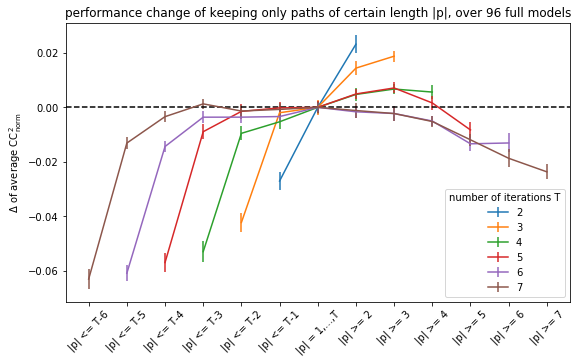

(2, 16, 'cm-last')
(96,) (864,)


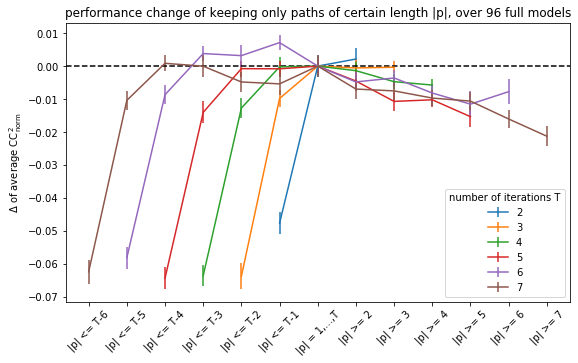

(2, 16, 'inst-avg')
(96,) (864,)


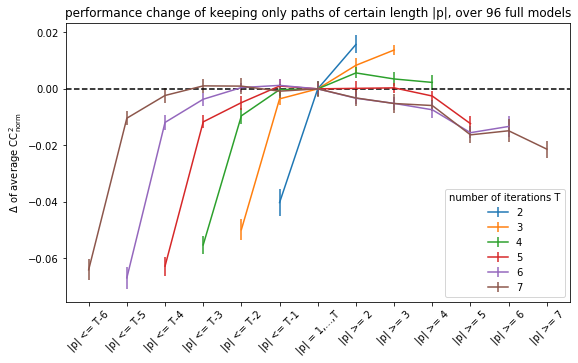

(2, 16, 'inst-last')
(96,) (864,)


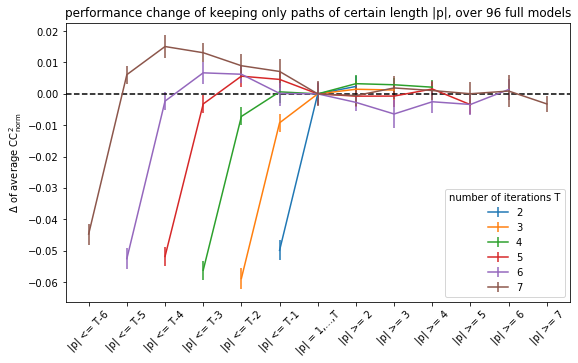

(2, 32, 'cm-avg')
(88,) (864,)


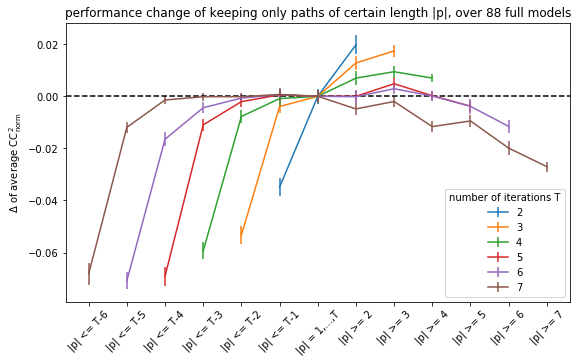

(2, 32, 'cm-last')
(88,) (864,)


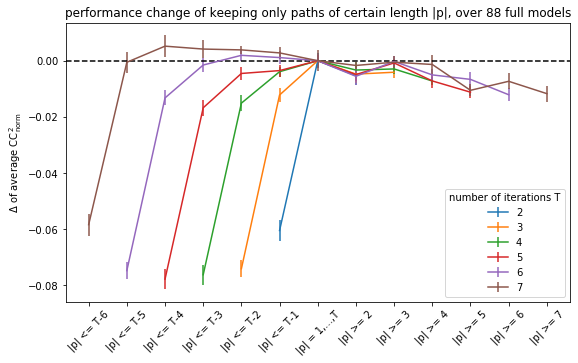

(2, 32, 'inst-avg')
(88,) (864,)


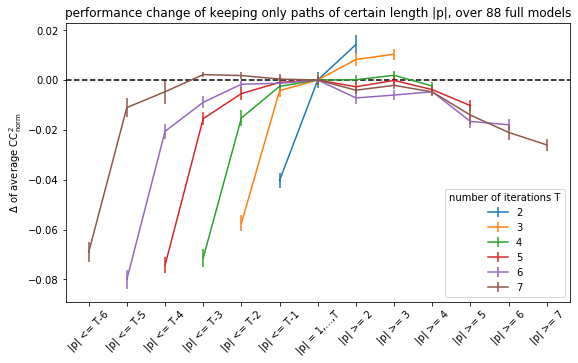

(2, 32, 'inst-last')
(88,) (864,)


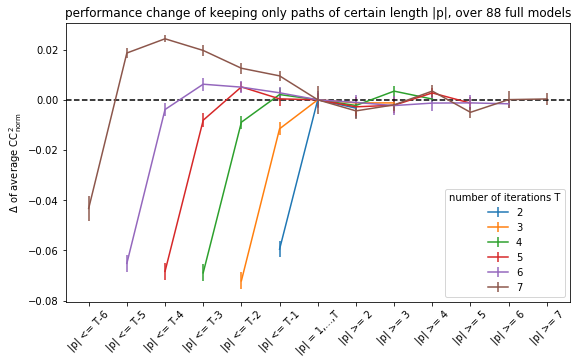

overall
(736,) (6912,)


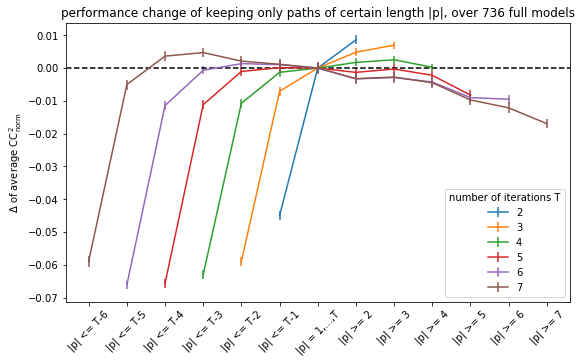

In [17]:
main_loop(df_main_result)